In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/rl"
train_path = "/content/drive/MyDrive/rl/tumor/Training/meningioma_tumor"
test_path = "/content/drive/MyDrive/rl/tumor/Testing/meningioma_tumor"

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from skimage import color
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import patches

In [ ]:
def load_data():
    # Load and preprocess your brain image dataset here
    # Return X_train (input images) and y_train (lesion annotations)
    train_indices = [2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28,
                     29, 30, 37, 38, 39, 40, 50, 51, 52, 53, 54, 55, 65, 66,
                     67, 68, 69, 70, 71, 72, 73, 74, 75, 81, 82, 83, 84, 85, 86,
                     108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 121,
                     123, 124, 125, 126]
    test_indices = [2, 3, 5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24,
                    26, 28, 29, 30, 31, 32, 52]
    train_imgs = []
    test_imgs = []
    for i in train_indices:
      img = Image.open(f"{train_path}/m ({i}).jpg").resize((224, 224))
      gray = color.rgb2gray(img)
      train_imgs.append(gray)
    for i in test_indices:
      img = Image.open(f"{test_path}/image({i}).jpg").resize((224, 224))
      gray = color.rgb2gray(img)
      test_imgs.append(gray)
    return np.array(train_imgs), np.array(test_imgs)

In [ ]:
def vectorize(labels, size=16):
  ret = []
  for label in labels:
    vec = np.zeros(size)
    for block in label:
      vec[block] = 1
    ret.append(vec)
  return np.array(ret)

In [ ]:
X_train, X_test = load_data()

In [ ]:
y_train = [[7], [7], [10, 14], [10], [10], [10], [10], [10], [5, 6], [5,6], [5,6], [5,6], [5,6], [6], [5,6],
           [5,6], [5,6], [5,6], [5,6], [9], [9], [9], [9], [5,6], [5,6], [5,6], [5,6], [5,6], [5], [5], [5],
           [5], [5], [5], [6], [6], [6], [6], [6], [6], [2], [2], [2], [2], [6], [2, 6], [9], [9], [9], [9],
           [9], [9], [6], [6], [5], [5], [5], [5], [9], [9], [9], [9]]
y_test = [[1,2,5,6], [9], [6, 10], [6, 10], [10, 11, 14, 15], [10, 11], [6, 7, 10, 11], [9, 10], [9, 13], [5], [4, 5, 8, 9],
          [8, 9], [4, 5], [1, 2], [1, 2, 5, 6], [9, 10], [10, 11], [9, 13], [1,2], [6, 7, 10, 11], [1, 5], [1], [6], [6, 10], [8, 9]]

In [ ]:
y_train = vectorize(y_train)
y_test = vectorize(y_test)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = []
        self.q_network = self._build_q_network()
        self.target_network = self._build_q_network()
        self.update_target_network()

    def _build_q_network(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.state_shape),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.action_size)
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state = np.expand_dims(state, axis=0)
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        batch = np.random.choice(len(self.memory), batch_size)
        for idx in batch:
            state, action, reward, next_state, done = self.memory[idx]
            target = reward
            state = np.expand_dims(state, axis=0)
            next_state = np.expand_dims(next_state, axis=0)
            if not done:
              target = reward + self.gamma * np.amax(self.target_network.predict(next_state, verbose=0)[0])
            target_f = self.q_network.predict(state, verbose=0)
            target_f[0][action] = target
            self.q_network.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Assuming you have a function to divide each image into 16 regions
def divide_image(image):
    grids = []
    for row in range(4):
      for col in range(4):
        grid = image[row * 56 : (row + 1) * 56, col * 56 : (col + 1) * 56]
        grids.append(grid)
    return np.array(grids)

def calculate_reward(current_state, next_state, label_vec):
    # Check if the agent stays still in a lesion state
    lesion_presence = (label_vec[next_state] == 1)
    if current_state == next_state and lesion_presence:
        return 1.0
    # Check if the agent moves to a lesion state
    elif current_state != next_state and lesion_presence:
        return 1.0
    # Check if the agent moves to a non-lesion state
    elif current_state != next_state and not lesion_presence:
        return -0.5
    # Check if the agent stays still in a non-lesion state
    elif current_state == next_state and not lesion_presence:
        return -2.0
    else:
        return 0.0  # No reward otherwise

In [ ]:
def step(state_num, action):
  if action == 0:
    return state_num
  elif action == 1:
    if state_num > 11:
      return state_num
    else:
      return state_num + 4
  else:
    if state_num % 4 == 3:
      return state_num
    else:
      return state_num + 1

In [ ]:
state_shape = (56, 56, 1)
action_size = 3 # 0) stay still, 1) move down, 2) move right

In [ ]:
# Initialize DQN agent
agent = DQNAgent(state_shape, action_size)

# Train the agent
batch_size = 3
episodes = 10
for episode in range(episodes):
    for i in range(len(X_train)):
        # print(episode, i)
        image = X_train[i]
        regions = divide_image(image)
        for state_num in range(len(regions)):
          print(episode, i, state_num)
          state = regions[state_num]
          action = agent.act(state)
          # Execute the action (e.g., move down or move right)
          # Calculate reward based on the presence of lesion in this region
          next_state_num = step(state_num, action)
          next_state = regions[next_state_num]
          reward = calculate_reward(state_num, next_state_num, y_train[i])
          done = True if y_train[i][next_state_num] == 1 else False # Assuming single step episodes
          agent.remember(state, action, reward, next_state, done)
          # print(len(agent.memory))
          if len(agent.memory) > batch_size:
              agent.replay(batch_size)
        agent.update_target_network()

In [ ]:
import pickle
def save_agent(agent, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(agent, f)

def load_agent(filepath):
    with open(filepath, 'rb') as f:
        agent = pickle.load(f)
    return agent

In [ ]:
save_agent(agent, base_path + "/agent")

In [ ]:
max_steps = 15

def test_agent(agent, img):
    results = []
    regions = divide_image(img)
    state_num = 0
    for _ in range(max_steps):
      state = regions[state_num]
      action = agent.act(state)
      next_state_num = step(state_num, action)
      results.append((state_num, action, next_state_num))
      state_num = next_state_num
    return results

In [ ]:
test_steps = []
for img, label in zip(X_test, y_test):
  res = test_agent(agent, img)
  test_steps.append(res)

In [ ]:
def show_grids(img, steps):
  grids = divide_image(img)
  fig, ax = plt.subplots(4, 4)
  for row in range(4):
    for col in range(4):
      ax[row][col].imshow(grids[row * 4 + col], cmap='gray')
      ax[row][col].axis('off')


  for state_num, action, next_state_num in steps:
    if action == 0 or state_num == next_state_num:
      continue
    else:
      a1, a2 = ax[state_num // 4][state_num % 4], ax[next_state_num // 4][next_state_num % 4]
      a1_center = (np.mean(a1.get_xlim()), np.mean(a1.get_ylim()))
      a2_center = (np.mean(a2.get_xlim()), np.mean(a2.get_ylim()))

      ax1tr = a1.transData # Axis 0 -> Display
      ax2tr = a2.transData # Axis 1 -> Display
      figtr = fig.transFigure.inverted() # Display -> Figure

      # 2. Transform arrow start point from axis 0 to figure coordinates
      ptB = figtr.transform(ax1tr.transform(a1_center))
      # 3. Transform arrow end point from axis 1 to figure coordinates
      ptE = figtr.transform(ax2tr.transform(a2_center))
      # 4. Create the patch
      arrow = patches.FancyArrowPatch(
          ptB, ptE, transform=fig.transFigure,  # Place arrow in figure coord system
          fc = "y", arrowstyle='simple', alpha = 0.7,
          mutation_scale = 20
      )
      # 5. Add patch to list of objects to draw onto the figure
      fig.patches.append(arrow)

In [ ]:
test_steps = np.array(test_steps)
np.save(base_path + "/test_steps.npy", test_steps)

In [ ]:
test_steps = np.load(base_path + "/test_steps.npy")

In [ ]:
for idx in range(len(X_test)):
  print(idx)
  show_grids(X_test[idx], test_steps[idx])

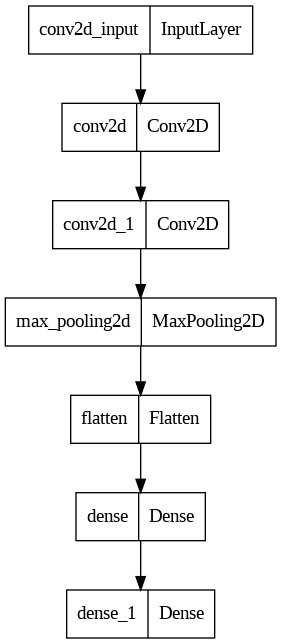

In [ ]:
tf.keras.utils.plot_model(agent.q_network, to_file=base_path + "/model.png")